In [1]:
import python_utils.python_utils.caching as caching
import data_run.problem_props_data_run.problem_props_data_run.constants as constants
caching.init(constants.cache_folder, constants.which_hash)
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display_pretty, display_html
import python_utils.python_utils.basic as basic
import data.problem_props_data.problem_props_data.fxns as ppd_fxns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mpl_colors
import matplotlib.cm as cm
import pdb
import GPy
import numpy as np
from sklearn import cross_validation
import python_utils.python_utils.sklearn_utils as sklearn_utils
import ml_stuff.ml_stuff.multinomial_mixture_EM as multinomial_mixture_EM
import itertools
import string
import statsmodels.nonparametric.kernel_regression as kernel_regression
import sklearn.cross_validation as cross_validation
import ml_stuff.ml_stuff.kernel_regression as KR

In [3]:
# get the raw (has call) data
unfiltered_data = ppd_fxns.raw_data()
print 'shape', unfiltered_data.shape
4
unfiltered_data.head()

shape (1019061, 16)


,ENTRY_DT,propID,MajorMed,YouthHealth,Alcohol,SocDis,PrivateConflict,Violence,Guns,Xkm,Ykm,type,SAM_ID,lngs,lats,TLID
1,15619,A10006,0,0,0,0,0,0,0,69776.83066,273858.6011,0,10006,-71.150292,42.336163,85696010
2,15619,A10006,0,0,0,0,0,0,0,69776.83066,273858.6011,0,10006,-71.150292,42.336163,85696010
3,15620,A10006,0,0,0,0,0,0,0,69776.83066,273858.6011,0,10006,-71.150292,42.336163,85696010
4,15621,A10006,0,0,0,0,0,0,0,69776.83066,273858.6011,0,10006,-71.150292,42.336163,85696010
5,15620,A10006,0,0,0,0,0,0,0,69776.83066,273858.6011,0,10006,-71.150292,42.336163,85696010


In [4]:
# filter raw (has call) data
from sklearn.pipeline import Pipeline
filter_df_pipeline = Pipeline([\
                               ('types', ppd_fxns.filter_by_types([1,3,4])),\
                               ('prop', ppd_fxns.filter_df_by_sampling('SAM_ID',.25)),\
                               ('outlier_lat', ppd_fxns.filter_df_by_percentile('lats', 1.,99.)),\
                               ('outlier_lng', ppd_fxns.filter_df_by_percentile('lngs', 1.,99.)),\
                               ('min_max', ppd_fxns.filter_by_num_calls(0,100)), \
                               ])
data = filter_df_pipeline.transform(unfiltered_data)
print 'number of calls:', data.shape[0]

0 100
number of calls: 22945


In [5]:
# get zero count data
unfiltered_zero_X_counts_df = ppd_fxns.zero_count_data()
print 'number of zero count properties:', unfiltered_zero_X_counts_df.shape[0]
unfiltered_zero_X_counts_df.head()

number of zero count properties: 259853


,lngs,lats
7,-71.057137,42.340617
10,-71.057137,42.340617
12,-71.053876,42.343116
14,-71.053563,42.343522
18,-71.052622,42.345118


In [6]:
# filter zero count data
filter_zero_X_counts_df_pipeline = Pipeline([\
                               ('prop', ppd_fxns.filter_df_by_sampling('index',.15)),\
                               ])
zero_X_counts_df = filter_zero_X_counts_df_pipeline.transform(unfiltered_zero_X_counts_df)
display_html(zero_X_counts_df.head().to_html(), raw=True)
print 'number of zero properties:', zero_X_counts_df.shape[0]

,lngs,lats
12,-71.053876,42.343116
36,-71.049369,42.349292
44,-71.049369,42.349292
45,-71.049369,42.349292
129,-71.103690,42.346310


number of zero properties: 38748


In [7]:
# data type 1a: convert filtered raw data to count data (for detecting anomalies)
X_counts_df, y_counts_series = ppd_fxns.convert_to_space_count().transform(data)
display_html(X_counts_df.head().to_html(), raw=True)
X_counts, y_counts = X_counts_df.values, y_counts_series.values
print 'number of non-zero properties:', X_counts.shape[0]

,lngs,lats
SAM_ID,,
8,-71.051143,42.347014
70,-71.086450,42.297394
80,-71.086246,42.297408
87,-71.086176,42.297206
99,-71.092331,42.314465


number of non-zero properties: 6491


In [8]:
# data type 1b: convert zero count data to X_counts, y_counts
zero_X_counts = zero_X_counts_df.values
zero_y_counts = np.zeros(zero_X_counts.shape[0])

In [9]:
# data type 1: merge zero and non-zero arrays
all_X_counts = np.concatenate([X_counts, zero_X_counts])
all_y_counts = np.concatenate([y_counts, zero_y_counts])
print 'total properties (zero and nonzero):', all_X_counts.shape[0]

total properties (zero and nonzero): 45239


In [10]:
# data type 1(continued): define method to extract non_zero data from all_data
def non_zero_from_all(x):
    return x[0:len(X_counts)]

In [11]:
# data type 2: convert filtered raw data to multinomial counts for each property (for clustering)
X_multinomial_df = ppd_fxns.convert_to_type_counts().transform(data)
display_html(X_multinomial_df.head().to_html(), raw=True)
X_multinomial = X_multinomial_df.values

,1,3,4
8,1,0,2
70,1,0,1
80,0,0,1
87,1,0,1
99,0,0,2


In [12]:
# define method for predicting counts.
count_estimator = KR.kernel_regression_sklearn_wrapper(efficient=True)

In [13]:
# figure out bounds of lat/lng
min_lat, max_lat = min(X_counts[:,0]), max(X_counts[:,0])
min_lng, max_lng = min(X_counts[:,1]), max(X_counts[:,1])

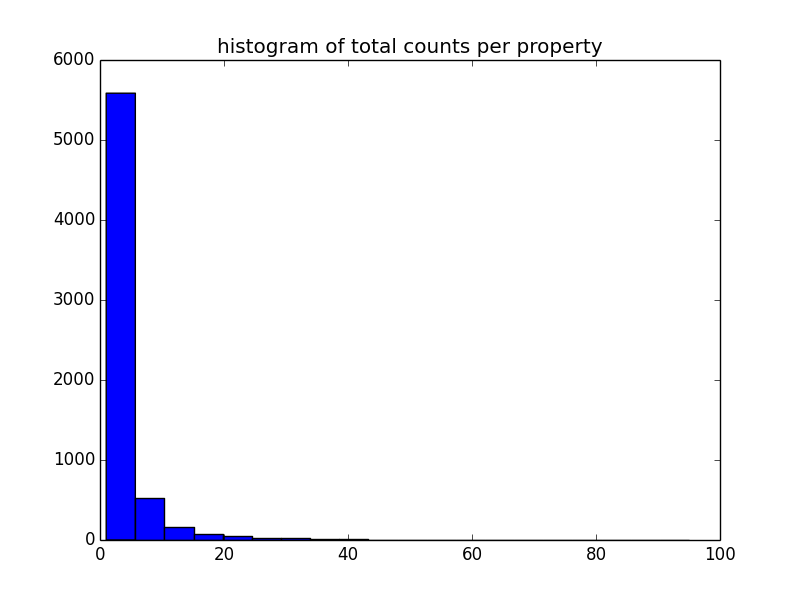

In [14]:
# plot histogram of y_counts
fig, ax = plt.subplots()
ax.hist(y_counts, bins=20)
ax.set_title('histogram of total counts per property')
basic.display_fig_inline(fig)

In [15]:
# print number of calls of each type
display_html(pd.DataFrame({'counts':X_multinomial.sum(axis=0)}).to_html(), raw=True)

,counts
0,11941
1,3129
2,7875


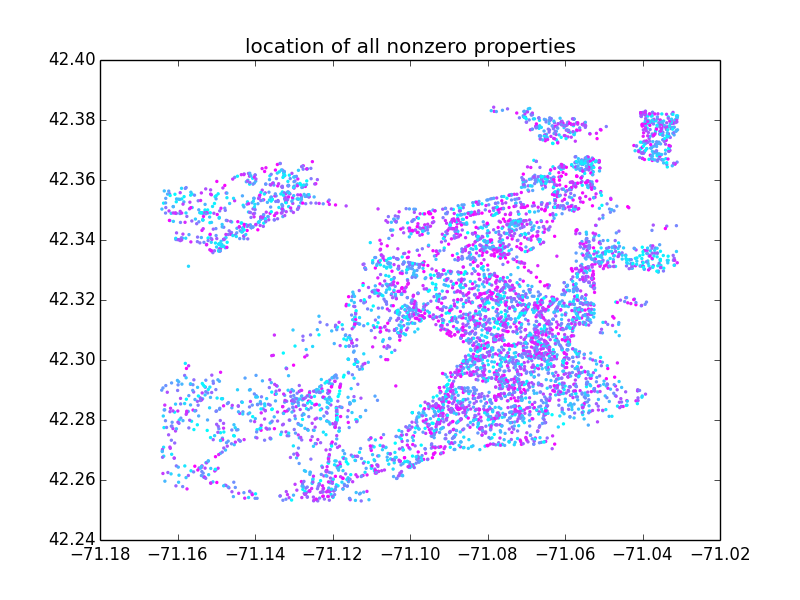

In [16]:
# display the X_counts, y_counts data
fig,ax = plt.subplots()
ax.scatter(X_counts[:,0],X_counts[:,1], color=basic.vals_to_rgbas(y_counts),s=2)
ax.set_title('location of all nonzero properties')
basic.display_fig_inline(fig)

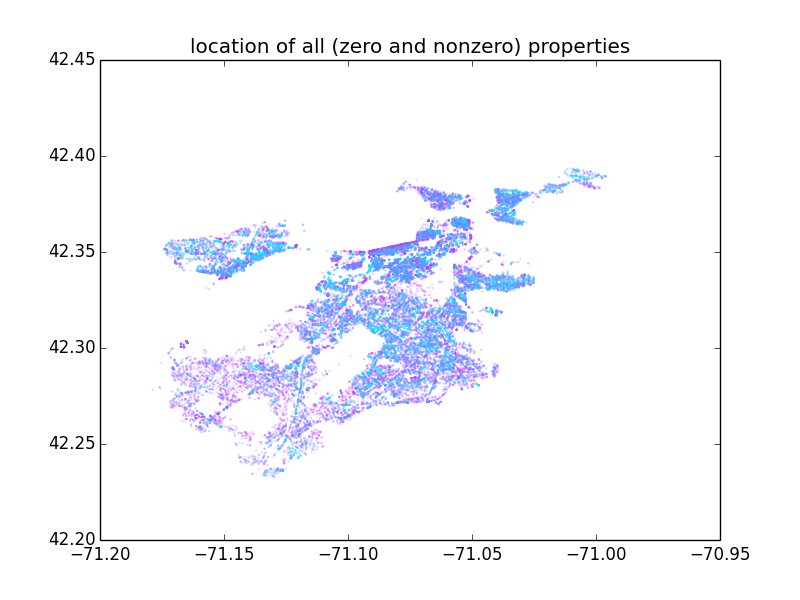

In [ ]:
# display the all_X_counts, all_y_counts data
fig,ax = plt.subplots()
ax.scatter(all_X_counts[:,0],all_X_counts[:,1], color=basic.vals_to_rgbas(all_y_counts),s=0.5, alpha=0.2)
ax.set_title('location of all (zero and nonzero) properties')
basic.display_fig_inline(fig)

In [ ]:
# get cross validated all predictions
predicted_all_y_counts = cross_validation.cross_val_predict(count_estimator, all_X_counts, all_y_counts)
#predicted_y_counts = count_estimator.fit(X_counts, y_counts).predict(X_counts)

In [ ]:
# print out some training info
pass

In [ ]:
# extract the non-zero predictions
predicted_y_counts = non_zero_from_all(predicted_all_y_counts)

In [ ]:
# plot predicted counts in space
fig, ax = plt.subplots()
ax.scatter(X_counts[:,0], X_counts[:,1], color=basic.vals_to_rgbas(predicted_y_counts), s=2)
ax.set_title('predicted counts')
basic.display_fig_inline(fig)

# plot heatmap of predicted counts
num_lng, num_lat = 100, 100
min_color_percentile, max_color_percentile = 5, 95
lats = np.arange(min_lat, max_lat, (max_lat-min_lat)/num_lat)
lngs = np.arange(min_lng, max_lng, (max_lng-min_lng)/num_lng)
mesh_lngs, mesh_lats = np.meshgrid(lngs, lats)
mesh_counts = count_estimator.predict(np.array([mesh_lngs.reshape(num_lng*num_lat),mesh_lats.reshape(num_lng*num_lat)]).T).reshape(num_lng,num_lat)
fig, ax = plt.subplots()
ax.pcolor(mesh_lngs, mesh_lats, mesh_counts, cmap='RdBu', vmin=np.percentile(mesh_counts,min_color_percentile), vmax=np.percentile(mesh_counts,max_color_percentile))
ax.set_title('heat map of predicted counts, averaged over folds')
basic.display_fig_inline(fig)

In [ ]:
# histogram of predicted counts
fig,ax = plt.subplots()
ax.hist(predicted_y_counts)
ax.set_title('histogram of predicted counts')
basic.display_fig_inline(fig)

In [ ]:
# get the novelty scores
novelty_scores = predicted_y_counts / y_counts

In [ ]:
# plot histogram of novelty scores to see if there is a suggested cutoff for problem properties
fig, ax = plt.subplots()
ax.hist(novelty_scores,bins=10)
ax.set_title('histogram of novelty scores')
basic.display_fig_inline(fig)

In [ ]:
# for both kinds of data, get the subset that corresponds to problem properties
pp_cutoff = 150
pp_indices = np.argsort(-1.*novelty_scores)[0:pp_cutoff]
pp_X_counts = X_counts[pp_indices]
pp_y_counts = y_counts[pp_indices]
pp_X_multinomial = X_multinomial[pp_indices]

In [ ]:
# cluster problem properties multinomial counts
K = 4
clustering_num_iters, clustering_tol = 100, .001
pp_thetas, pp_pi, pp_loglik = multinomial_mixture_EM.multinomial_mixture_EM(clustering_num_iters, clustering_tol, K, pp_X_multinomial)
pp_Zs = multinomial_mixture_EM.assign_clusters(pp_thetas, pp_pi, pp_X_multinomial)

In [ ]:
# define mapping from cluster index to color
cluster_colors = np.array(['r','g','b','k','c'])

In [ ]:
# plot location of problem properties, colored by type
fig, ax = plt.subplots()
ax.scatter(pp_X_counts[:,0], pp_X_counts[:,1], color=cluster_colors[pp_Zs], s=2)
ax.set_title('location and cluster assignments of problem properties')
basic.display_fig_inline(fig)

In [ ]:
# define transform to plot multinomial_counts
pseudo_counts = np.ones(pp_X_multinomial.shape[1]) * .01
jitter = 0.03
per_transform = Pipeline([\
                          ('pseudo_counts', sklearn_utils.transform_from_fxn(lambda x: (x+pseudo_counts)/(x.sum()+pseudo_counts.sum()))),\
                          ('project', sklearn_utils.transform_from_fxn(lambda y:y[0:2])),\
                          ('jitter', sklearn_utils.transform_from_fxn(lambda z:(z+(jitter*np.random.random(size=len(z)))))),\
                          ])
plottable_transform = sklearn_utils.vectorize_transform(per_transform)

In [ ]:
# plot problem properties multinomial_counts, as well as cluster centers
pp_X_multinomial_plottable = plottable_transform.transform(pp_X_multinomial)
fig, ax = plt.subplots()
ax.scatter(pp_X_multinomial_plottable[:,0], pp_X_multinomial_plottable[:,1], color=cluster_colors[pp_Zs], s=2)
pp_thetas_plottable = plottable_transform.transform(pp_thetas)
ax.scatter(pp_thetas_plottable[:,0], pp_thetas_plottable[:,1], color=cluster_colors[0:K], s=5)
basic.display_fig_inline(fig)